SECOND PART

In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
from spacy import displacy

from collections import Counter
import matplotlib.pyplot as plt
from itertools import combinations
import networkx as nx
import numpy as np


In [125]:
import pickle

with open('/Users/andreavento/Documents/Elerian AI/Task 2 NER/Datasets/data_with_entities_new.pkl', 'rb') as file:
    data = pickle.load(file)

data['num_subj'] = data['pos_counts'].apply(lambda x: x.get('subj', 0))
data['num_adj'] = data['pos_counts'].apply(lambda x: x.get('adj', 0))
data['num_obj'] = data['pos_counts'].apply(lambda x: x.get('obj', 0))
data.drop('pos_counts', axis = 1, inplace=True)
print(data.isnull().sum())
data

Unified_Verdict           0
Text                      0
entities                  0
entity_verb_ratio         0
sentiment                 0
entities_relations_pos    0
relations                 0
num_subj                  0
num_adj                   0
num_obj                   0
dtype: int64


,Unified_Verdict,Text,entities,entity_verb_ratio,sentiment,entities_relations_pos,relations,num_subj,num_adj,num_obj
16870,1.0,iranian commander issued stark warning to iraq...,"[(iranian, NORP), (iraqi, NORP), (kirkuksulaim...",0.866197,-0.9954,"([(iranian, NORP), (iraqi, NORP), (kirkuksulai...","[(of, prep, couple, TIME), (hours, pobj, of, T...",11,44,36
1912,-1.0,trump just got ripped apart after demanding cl...,"[(demanding clinton, PERSON), (tweetsdonald tr...",0.571429,-0.9784,"([(demanding clinton, PERSON), (tweetsdonald t...",[],10,4,6
13421,1.0,eu agrees registration rules for drones downlo...,"[(europe, LOC), (europe, LOC), (european union...",0.457627,0.9153,"([(europe, LOC), (europe, LOC), (european unio...",[],2,5,8
10771,1.0,facebook twitter support apple on encryption d...,[(fbisan francisco reuters facebook inc fbo an...,0.407407,0.9892,([(fbisan francisco reuters facebook inc fbo a...,[],1,2,7
10972,1.0,civil rights activist deray mckesson running f...,"[(mckesson, PERSON), (baltimore mckesson, ORG)...",0.673913,-0.9886,"([(mckesson, PERSON), (baltimore mckesson, ORG...",[],5,6,13
...,...,...,...,...,...,...,...,...,...,...
13517,1.0,frances macron to give saudi arabia extremist ...,"[(saudi arabia, GPE), (reuters, ORG), (french,...",0.589286,0.6485,"([(saudi arabia, GPE), (reuters, ORG), (french...",[],5,9,14
13823,1.0,factbox proposals of main parties in honduras ...,"[(hondurans, NORP), (sunday, DATE), (second, O...",0.303797,-0.5854,"([(hondurans, NORP), (sunday, DATE), (second, ...","[(of, prep, university, ORG), (york, pobj, of,...",0,6,15
13696,-1.0,not kidding hillarys state department blocked ...,"[(muslim, NORP), (florida, GPE), (hillary, PER...",0.584416,0.6374,"([(muslim, NORP), (florida, GPE), (hillary, PE...",[],8,8,14
17238,-1.0,breaking obamas doj to fast track million to t...,"[(charleston, GPE), (about million, CARDINAL),...",0.923077,-0.8271,"([(charleston, GPE), (about million, CARDINAL)...",[],2,1,6


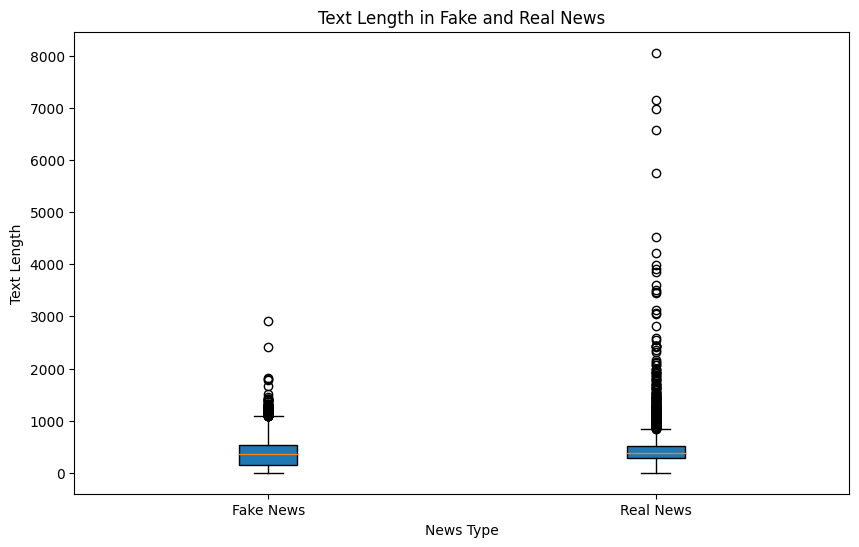

Summary statistics for Fake news:
count    6361.000000
mean      389.687785
std       267.063996
min         4.000000
25%       155.000000
50%       365.000000
75%       526.000000
max      2903.000000
Name: text_length, dtype: float64

Summary statistics for Real news:
count    5363.000000
mean      422.520977
std       368.895628
min         1.000000
25%       279.000000
50%       381.000000
75%       505.000000
max      8057.000000
Name: text_length, dtype: float64


In [126]:
data['text_length'] = data['Text'].apply(lambda x: len(x.split()))

# Separate the data into real and fake news
fake_news = data[data['Unified_Verdict'] == 1.0]
real_news = data[data['Unified_Verdict'] == -1.0]

# Generate boxplots for text length
boxplot_data = [fake_news['text_length'], real_news['text_length']]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=['Fake News', 'Real News'], patch_artist=True)
plt.title('Text Length in Fake and Real News')
plt.ylabel('Text Length')
plt.xlabel('News Type')
plt.show()

# Print summary statistics for text length
fake_summary = fake_news['text_length'].describe()
real_summary = real_news['text_length'].describe()

print("Summary statistics for Fake news:")
print(fake_summary)
print("\nSummary statistics for Real news:")
print(real_summary)

Real news, on average, tend to be longer and more detailed, consistently with these boxplots. Moreover, Fake news exhibit a significantly lower number of outliers for 'text lenght'

# Entities and Relationship Analysis

<Axes: xlabel='Unified_Verdict', ylabel='Count'>

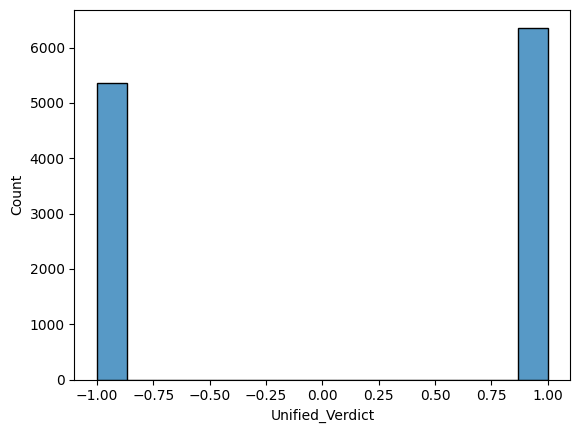

In [127]:
sns.histplot(data['Unified_Verdict'])

Since the Dataset is slightly imbalanced, we'll need to normalise the results we obtain in order to get meaningful results. 

In [128]:
all_entity_types = [entity[1] for sublist in data['entities'] for entity in sublist]

entity_type_counts = Counter(all_entity_types)
entity_type_counts_df = pd.DataFrame(entity_type_counts.items(), columns=['Entity Type', 'Count'])
entity_type_counts_df = entity_type_counts_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
print(entity_type_counts_df)

    Entity Type  Count
0           GPE  69550
1        PERSON  59230
2          DATE  51781
3          NORP  47477
4           ORG  46748
5      CARDINAL  20685
6       ORDINAL   6437
7          TIME   3986
8           LOC   3384
9         MONEY    970
10          FAC    626
11     QUANTITY    494
12        EVENT    412
13      PERCENT    328
14          LAW    212
15      PRODUCT    208
16     LANGUAGE    159
17  WORK_OF_ART    125


Let's separate Fake and Real news in order to appreciate the differences

In [129]:
fake_news = data[data['Unified_Verdict'] == 1.0].copy()
real_news = data[data['Unified_Verdict'] == -1.0].copy()

Sentiment distribution and boxplots

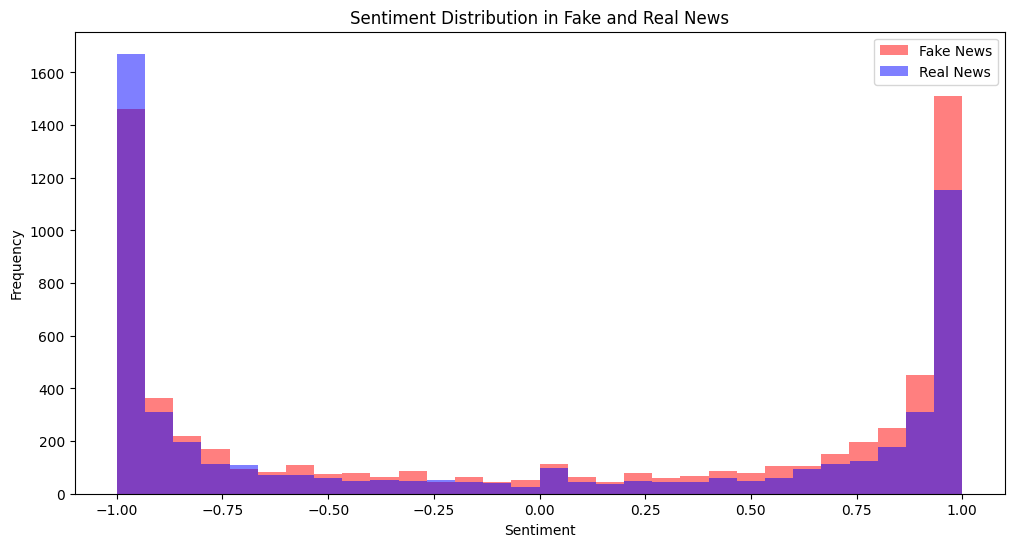

Summary statistics for Fake news:
count    6361.000000
mean        0.036583
std         0.832824
min        -0.999800
25%        -0.916900
50%         0.140400
75%         0.924600
max         0.999700
Name: sentiment, dtype: float64

Summary statistics for Real news:
count    5363.000000
mean       -0.094906
std         0.848614
min        -1.000000
25%        -0.963800
50%        -0.349800
75%         0.900100
max         1.000000
Name: sentiment, dtype: float64


In [130]:
plt.figure(figsize=(12, 6))

# Plot histogram for Fake News
plt.hist(fake_news['sentiment'], bins=30, alpha=0.5, label='Fake News', color='red')

# Plot histogram for Real News
plt.hist(real_news['sentiment'], bins=30, alpha=0.5, label='Real News', color='blue')

# Titles and labels
plt.title('Sentiment Distribution in Fake and Real News')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

# Summary statistics for Fake News
fake_summary = fake_news['sentiment'].describe()
print("Summary statistics for Fake news:")
print(fake_summary)

# Summary statistics for Real News
real_summary = real_news['sentiment'].describe()
print("\nSummary statistics for Real news:")
print(real_summary)

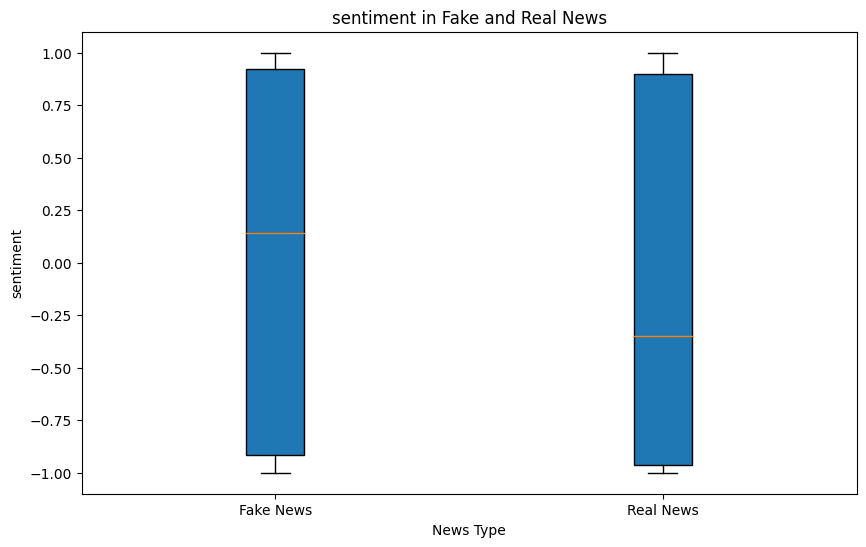

Summary statistics for Fake news:
count    6361.000000
mean        0.036583
std         0.832824
min        -0.999800
25%        -0.916900
50%         0.140400
75%         0.924600
max         0.999700
Name: sentiment, dtype: float64

Summary statistics for Real news:
count    5363.000000
mean       -0.094906
std         0.848614
min        -1.000000
25%        -0.963800
50%        -0.349800
75%         0.900100
max         1.000000
Name: sentiment, dtype: float64


In [131]:
boxplot_data = [fake_news['sentiment'], real_news['sentiment']]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data, labels=['Fake News', 'Real News'], patch_artist=True)
plt.title('sentiment in Fake and Real News')
plt.ylabel('sentiment')
plt.xlabel('News Type')
plt.show()

fake_summary = fake_news['sentiment'].describe()
real_summary = real_news['sentiment'].describe()

print("Summary statistics for Fake news:")
print(fake_summary)
print("\nSummary statistics for Real news:")
print(real_summary)

Despite the expectations, sentiment distribution is similar both in real and fake news.

Entity to verb ratio distribution

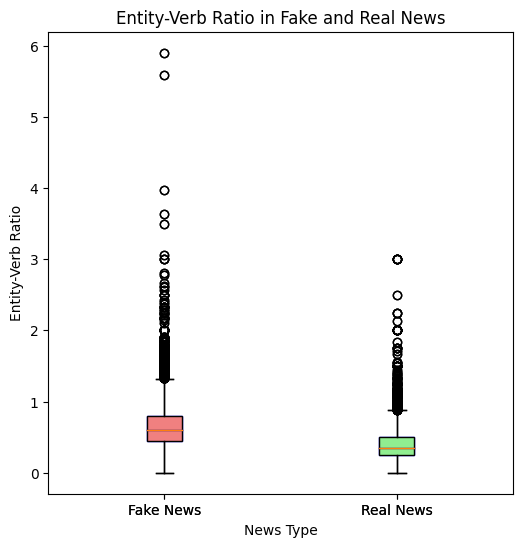

Summary statistics for Fake news:
count    6361.000000
mean        0.668660
std         0.340722
min         0.000000
25%         0.447917
50%         0.600000
75%         0.800000
max         5.900000
Name: entity_verb_ratio, dtype: float64

Summary statistics for Real news:
count    5363.000000
mean        0.402066
std         0.249296
min         0.000000
25%         0.250000
50%         0.352941
75%         0.500000
max         3.000000
Name: entity_verb_ratio, dtype: float64


In [168]:

boxplot_data = [fake_news['entity_verb_ratio'], real_news['entity_verb_ratio']]

plt.figure(figsize=(6, 6))
boxprops = dict(facecolor='lightblue', color='blue')
medianprops = dict(color='darkblue')
plt.boxplot(boxplot_data, labels=['Fake News', 'Real News'], patch_artist=True,
            boxprops=boxprops, medianprops=medianprops)

colors = ['lightcoral', 'lightgreen']
box = plt.boxplot(boxplot_data, patch_artist=True, labels=['Fake News', 'Real News'])

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.title('Entity-Verb Ratio in Fake and Real News')
plt.ylabel('Entity-Verb Ratio')
plt.xlabel('News Type')
plt.show()

fake_summary = fake_news['entity_verb_ratio'].describe()
print("Summary statistics for Fake news:")
print(fake_summary)

real_summary = real_news['entity_verb_ratio'].describe()
print("\nSummary statistics for Real news:")
print(real_summary)

As we can see, Fake news tend to exhibit higher entity to verb ratio. This is consistent with the hypothesis that Real news tend to prive lots of details and descriptive information within articles, while Fake ones have a 'sensational oriented' approach, including more entities for each verb on average. 

Number of entities: is it different in real and fake news?

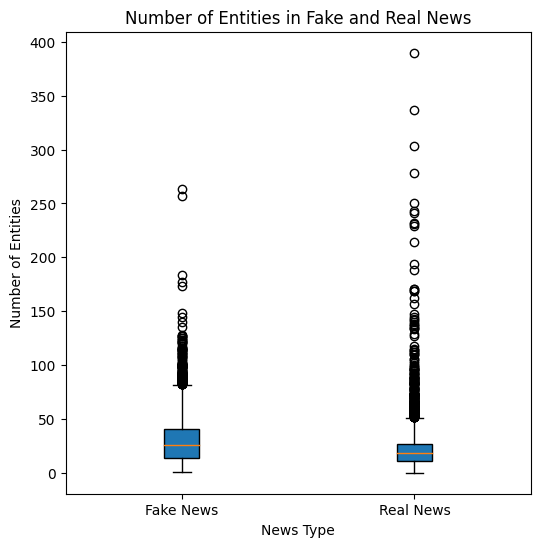

Summary statistics for Fake news:
count    6361.000000
mean       30.837604
std        21.414211
min         1.000000
25%        14.000000
50%        26.000000
75%        41.000000
max       263.000000
Name: num_entities, dtype: float64

Summary statistics for Real news:
count    5363.000000
mean       21.751632
std        20.726020
min         0.000000
25%        11.000000
50%        18.000000
75%        27.000000
max       390.000000
Name: num_entities, dtype: float64


In [166]:
fake_news['num_entities'] = fake_news['entities'].apply(len)
real_news['num_entities'] = real_news['entities'].apply(len)

boxplot_data = [fake_news['num_entities'], real_news['num_entities']]

plt.figure(figsize=(6, 6))
plt.boxplot(boxplot_data, labels=['Fake News', 'Real News'], patch_artist=True)
plt.title('Number of Entities in Fake and Real News')
plt.ylabel('Number of Entities')
plt.xlabel('News Type')
plt.show()

fake_summary = fake_news['num_entities'].describe()
real_summary = real_news['num_entities'].describe()

print("Summary statistics for Fake news:")
print(fake_summary)
print("\nSummary statistics for Real news:")
print(real_summary)

Aligned with the entity to verb ratio considerations, Fake news tend to exhibit an higher number of entities with respect to real ones. 

Fake News average entity types: 6.229680867788083
Real News average entity types: 5.471750885698303


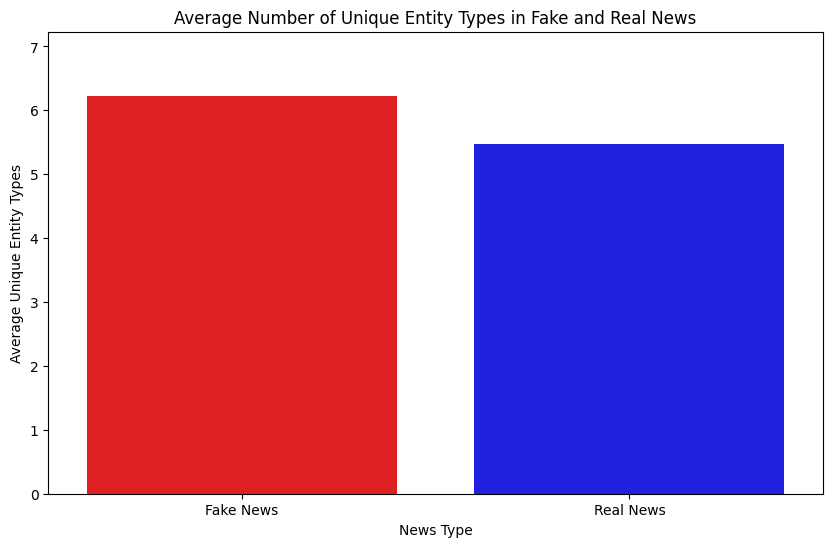

In [134]:
def count_unique_entity_types(entities):
    entity_types = set([ent[1] for ent in entities])
    return len(entity_types)


fake_news['unique_entity_types_count'] = fake_news['entities'].apply(count_unique_entity_types)
real_news['unique_entity_types_count'] = real_news['entities'].apply(count_unique_entity_types)

fake_avg_unique_entity_types = fake_news['unique_entity_types_count'].mean()
real_avg_unique_entity_types = real_news['unique_entity_types_count'].mean()

print('Fake News average entity types:', fake_avg_unique_entity_types)
print('Real News average entity types:', real_avg_unique_entity_types)

avg_unique_entity_types_df = pd.DataFrame({
    'News Type': ['Fake News', 'Real News'],
    'Average Unique Entity Types': [fake_avg_unique_entity_types, real_avg_unique_entity_types]
})


plt.figure(figsize=(10, 6))
sns.barplot(x='News Type', y='Average Unique Entity Types', data=avg_unique_entity_types_df, palette=['red', 'blue'])
plt.title('Average Number of Unique Entity Types in Fake and Real News')
plt.ylabel('Average Unique Entity Types')
plt.xlabel('News Type')
plt.ylim(0, max(avg_unique_entity_types_df['Average Unique Entity Types']) + 1)  
plt.show()

Fake news tend to include more entity types than real ones. 

POS analysis count:

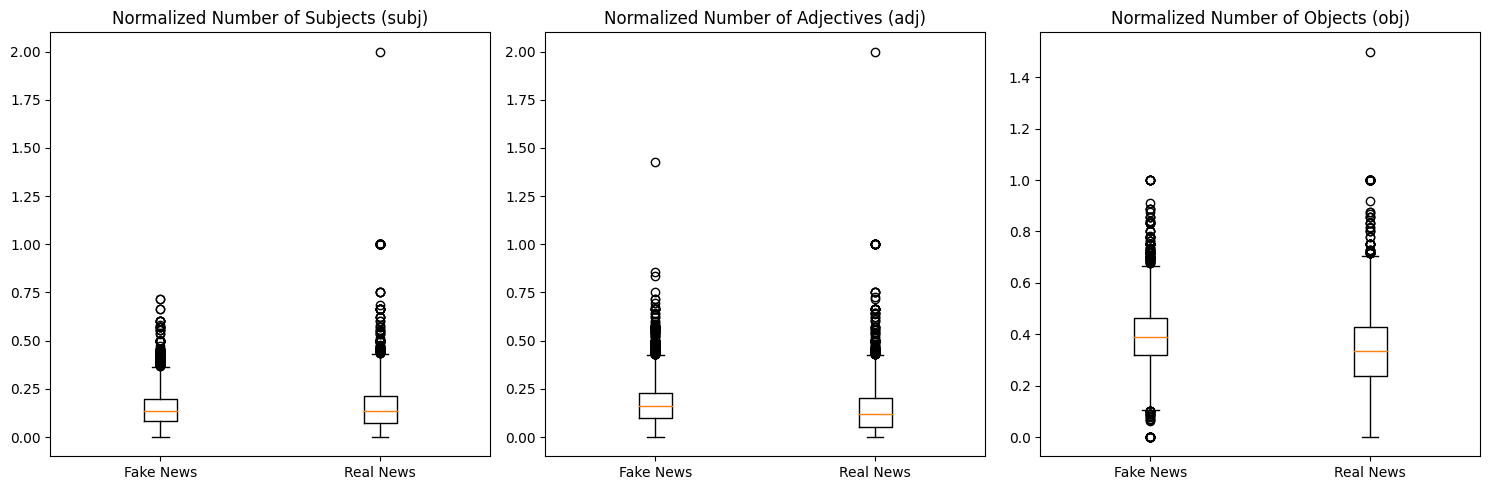

In [135]:
fake_news['norm_subj'] = fake_news['num_subj'] / fake_news['num_entities']
fake_news['norm_adj'] = fake_news['num_adj'] / fake_news['num_entities']
fake_news['norm_obj'] = fake_news['num_obj'] / fake_news['num_entities']

real_news['norm_subj'] = real_news['num_subj'] / real_news['num_entities']
real_news['norm_adj'] = real_news['num_adj'] / real_news['num_entities']
real_news['norm_obj'] = real_news['num_obj'] / real_news['num_entities']

# Plotting box plots
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Box plot for normalized num_subj
axs[0].boxplot([fake_news['norm_subj'].dropna(), real_news['norm_subj'].dropna()], labels=['Fake News', 'Real News'])
axs[0].set_title('Normalized Number of Subjects (subj)')

# Box plot for normalized num_adj
axs[1].boxplot([fake_news['norm_adj'].dropna(), real_news['norm_adj'].dropna()], labels=['Fake News', 'Real News'])
axs[1].set_title('Normalized Number of Adjectives (adj)')

# Box plot for normalized num_obj
axs[2].boxplot([fake_news['norm_obj'].dropna(), real_news['norm_obj'].dropna()], labels=['Fake News', 'Real News'])
axs[2].set_title('Normalized Number of Objects (obj)')

# Show plots
plt.tight_layout()
plt.show()

Leaving out the 'higher number effect' in Fake news by normalizing the counts, Fake news contain more 'substantial' POS (adjectives, subjects, objects) when compared to Real ones. This is expected as Real news tend to focus relatively more on the descriptive part of the information rather than the 'sensational' one. 

Let's now look at the specific entities

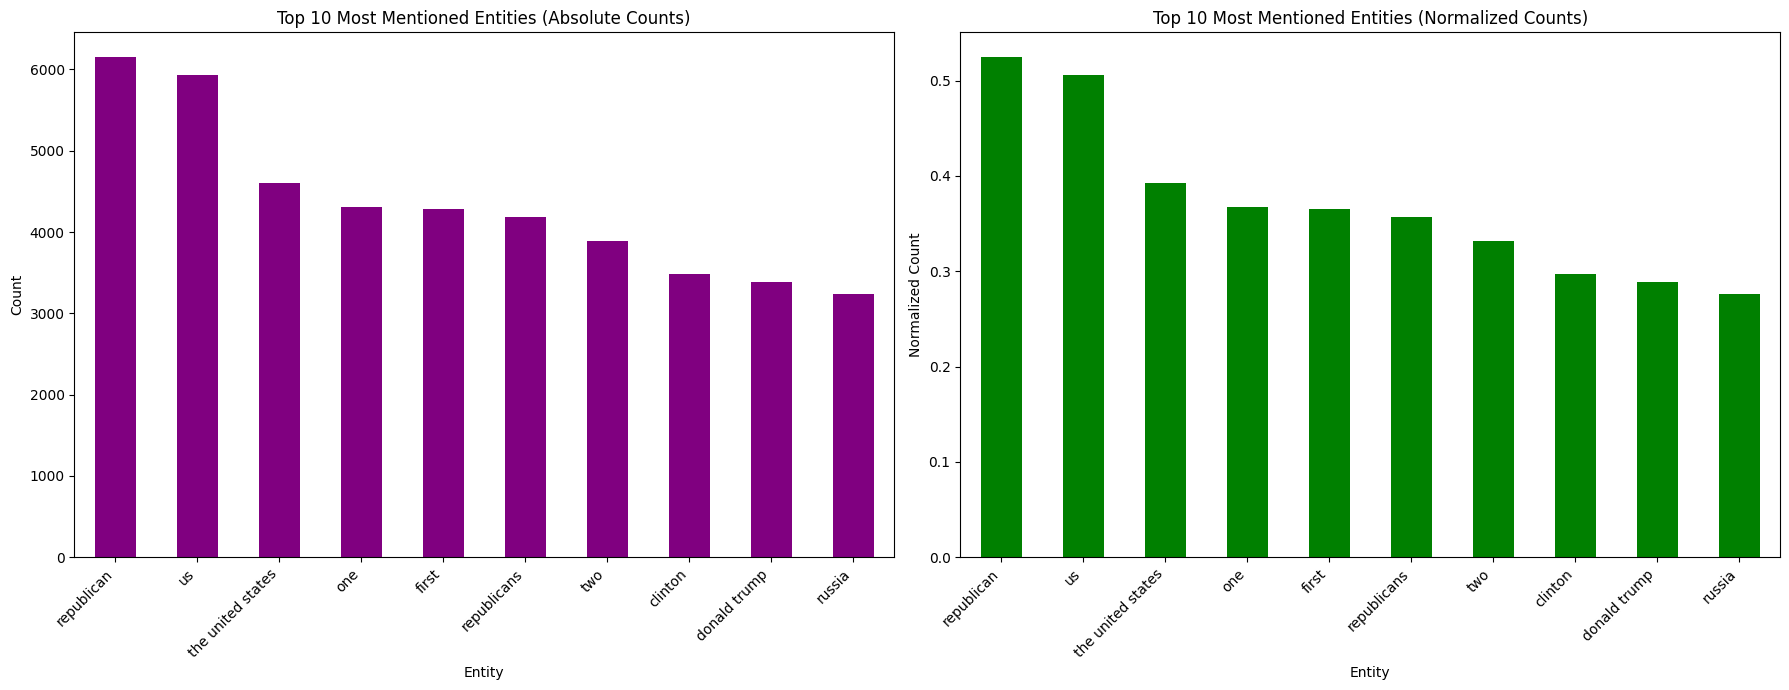

In [136]:
all_entities = [entity for sublist in data['entities'] for entity in sublist]

entity_counts = Counter([ent[0] for ent in all_entities])

# The 10 most common entities
top_entities = entity_counts.most_common(10)

# Normalization to see the average count per observation of each entity
top_entities_df = pd.DataFrame(top_entities, columns=['Entity', 'Count'])
total_entities = len(all_entities)
entity_counts_normalized = {entity: count / len(data) for entity, count in entity_counts.items()}
top_entities_normalized = Counter(entity_counts_normalized).most_common(10)
top_entities_normalized_df = pd.DataFrame(top_entities_normalized, columns=['Entity', 'Normalized Count'])

# Plot
fig, axes = plt.subplots(ncols=2, figsize=(18, 7))

# Absolute counts
top_entities_df.plot(kind='bar', x='Entity', y='Count', ax=axes[0], legend=False, color='purple')
axes[0].set_title('Top 10 Most Mentioned Entities (Absolute Counts)')
axes[0].set_ylabel('Count')
axes[0].set_xlabel('Entity')
axes[0].set_xticklabels(top_entities_df['Entity'], rotation=45, ha='right')

# Normalized counts
top_entities_normalized_df.plot(kind='bar', x='Entity', y='Normalized Count', ax=axes[1], legend=False, color='green')
axes[1].set_title('Top 10 Most Mentioned Entities (Normalized Counts)')
axes[1].set_ylabel('Normalized Count')
axes[1].set_xlabel('Entity')
axes[1].set_xticklabels(top_entities_normalized_df['Entity'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

As we can see, the entities 'republican' and 'us' is mentioned in half the articles on average.

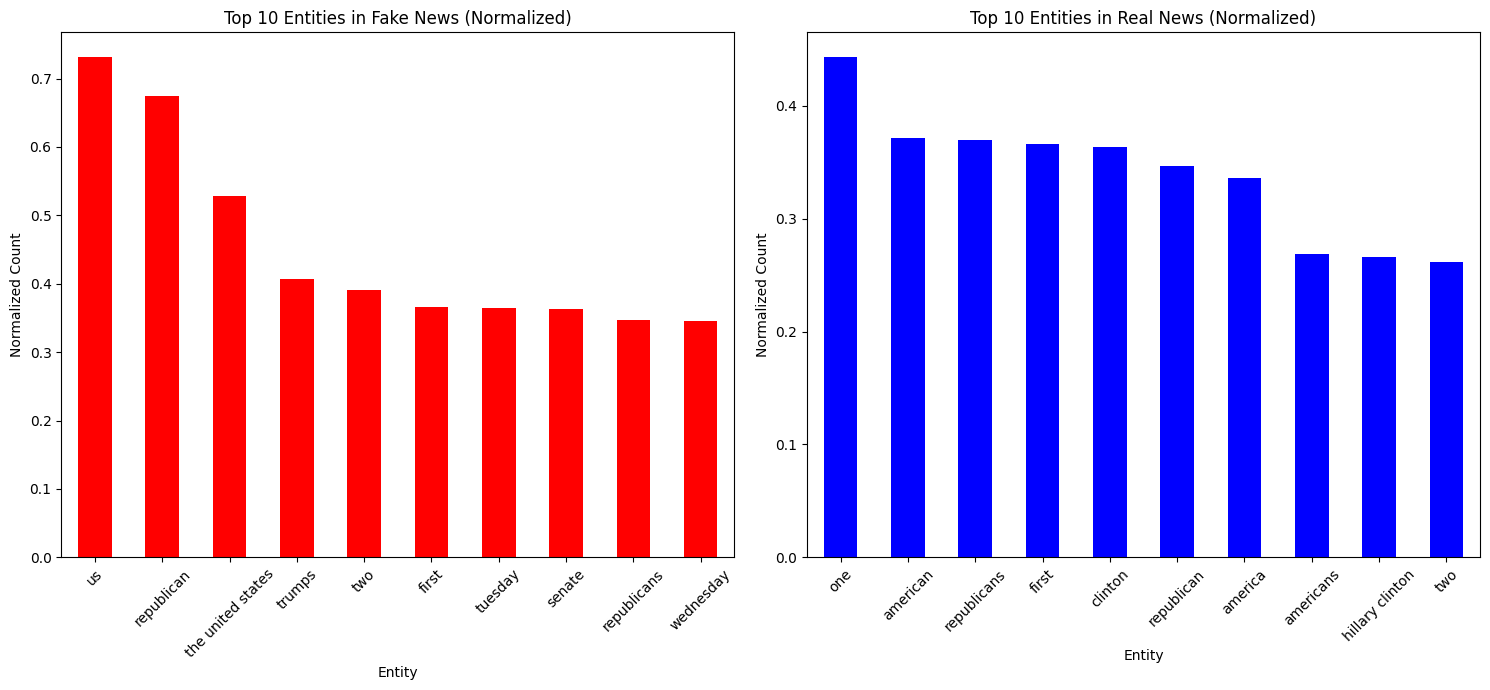

In [137]:

fake_entities = [entity for sublist in fake_news['entities'] for entity in sublist]
real_entities = [entity for sublist in real_news['entities'] for entity in sublist]

fake_entity_counts = Counter([ent[0] for ent in fake_entities])
real_entity_counts = Counter([ent[0] for ent in real_entities])

total_fake = len(fake_news)
total_real = len(real_news)

fake_entity_counts_normalized = {entity: count / total_fake for entity, count in fake_entity_counts.items()}
real_entity_counts_normalized = {entity: count / total_real for entity, count in real_entity_counts.items()}

fake_top_10_normalized = Counter(fake_entity_counts_normalized).most_common(10)
real_top_10_normalized = Counter(real_entity_counts_normalized).most_common(10)

fake_top_10_df = pd.DataFrame(fake_top_10_normalized, columns=['Entity', 'Normalized Count'])
real_top_10_df = pd.DataFrame(real_top_10_normalized, columns=['Entity', 'Normalized Count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

fake_top_10_df.plot(kind='bar', x='Entity', y='Normalized Count', ax=axes[0], legend=False, color='red')
axes[0].set_title('Top 10 Entities in Fake News (Normalized)')
axes[0].set_ylabel('Normalized Count')
axes[0].set_xlabel('Entity')
axes[0].set_xticklabels(fake_top_10_df['Entity'], rotation=45)

real_top_10_df.plot(kind='bar', x='Entity', y='Normalized Count', ax=axes[1], legend=False, color='blue')
axes[1].set_title('Top 10 Entities in Real News (Normalized)')
axes[1].set_ylabel('Normalized Count')
axes[1].set_xlabel('Entity')
axes[1].set_xticklabels(real_top_10_df['Entity'], rotation=45)

plt.tight_layout()
plt.show()


'Republican' and 'us' appear in Fake News with a higher rate with respect to the total average. Including dummy variables for the presence of these instances could be beneficial for the predictive ability of our model. 

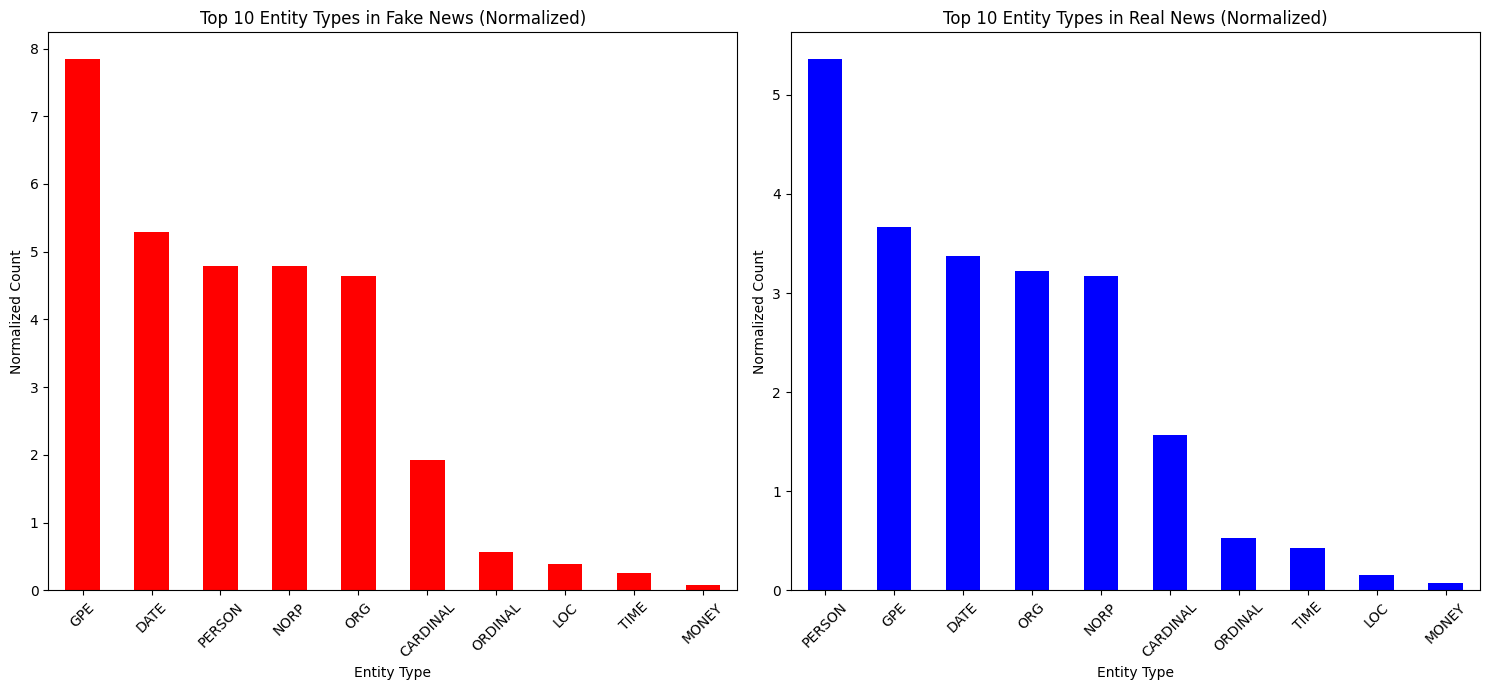

In [138]:
fake_entity_types = [entity[1] for sublist in fake_news['entities'] for entity in sublist]
real_entity_types = [entity[1] for sublist in real_news['entities'] for entity in sublist]

fake_entity_type_counts = Counter(fake_entity_types)
real_entity_type_counts = Counter(real_entity_types)

total_fake = len(fake_news)
total_real = len(real_news)

fake_entity_type_counts_normalized = {entity_type: count / total_fake for entity_type, count in fake_entity_type_counts.items()}
real_entity_type_counts_normalized = {entity_type: count / total_real for entity_type, count in real_entity_type_counts.items()}

fake_top_10_entity_types_normalized = Counter(fake_entity_type_counts_normalized).most_common(10)
real_top_10_entity_types_normalized = Counter(real_entity_type_counts_normalized).most_common(10)

fake_top_10_entity_types_df = pd.DataFrame(fake_top_10_entity_types_normalized, columns=['Entity Type', 'Normalized Count'])
real_top_10_entity_types_df = pd.DataFrame(real_top_10_entity_types_normalized, columns=['Entity Type', 'Normalized Count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 7))

fake_top_10_entity_types_df.plot(kind='bar', x='Entity Type', y='Normalized Count', ax=axes[0], legend=False, color='red')
axes[0].set_title('Top 10 Entity Types in Fake News (Normalized)')
axes[0].set_ylabel('Normalized Count')
axes[0].set_xlabel('Entity Type')
axes[0].set_xticklabels(fake_top_10_entity_types_df['Entity Type'], rotation=45)

real_top_10_entity_types_df.plot(kind='bar', x='Entity Type', y='Normalized Count', ax=axes[1], legend=False, color='blue')
axes[1].set_title('Top 10 Entity Types in Real News (Normalized)')
axes[1].set_ylabel('Normalized Count')
axes[1].set_xlabel('Entity Type')
axes[1].set_xticklabels(real_top_10_entity_types_df['Entity Type'], rotation=45)

plt.tight_layout()
plt.show()

As we can see, there are a few differences in the top-mentioned entities in Fake and Real news. 
In particular, the 'GPE' entity, indicating ' Countries, cities, states' is substantially more frequent in Fake News than in Real ones. 

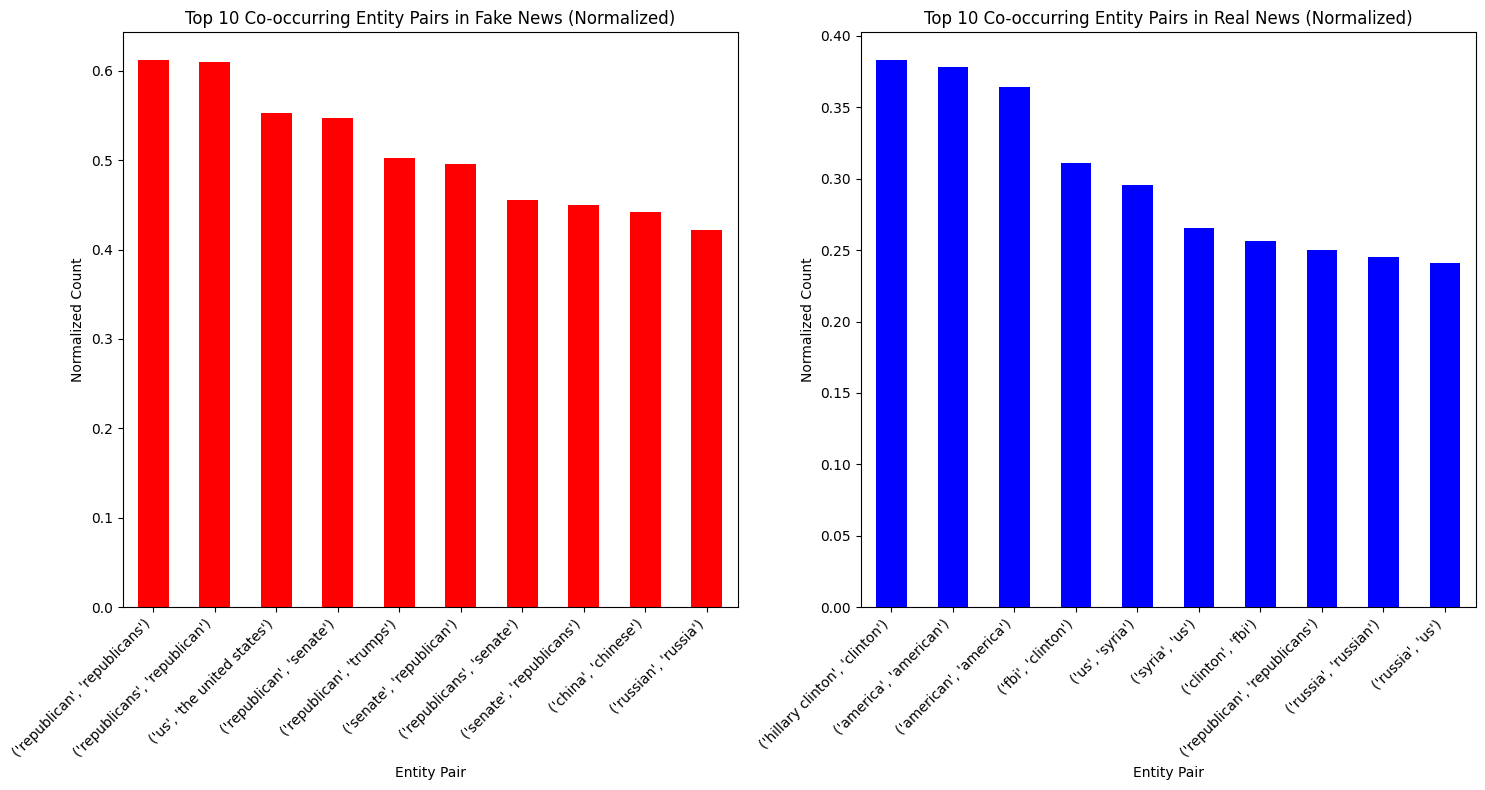

In [139]:
def get_entity_pairs(entities):
    return [pair for pair in combinations([ent[0] for ent in entities], 2) if pair[0] != pair[1]]

fake_entity_pairs = [pair for sublist in fake_news['entities'] for pair in get_entity_pairs(sublist)]
real_entity_pairs = [pair for sublist in real_news['entities'] for pair in get_entity_pairs(sublist)]

fake_pair_counts = Counter(fake_entity_pairs)
real_pair_counts = Counter(real_entity_pairs)

total_fake_articles = len(fake_news)
total_real_articles = len(real_news)

fake_pair_counts_normalized = {pair: count / total_fake_articles for pair, count in fake_pair_counts.items()}
real_pair_counts_normalized = {pair: count / total_real_articles for pair, count in real_pair_counts.items()}

fake_top_pairs_normalized = Counter(fake_pair_counts_normalized).most_common(10)
real_top_pairs_normalized = Counter(real_pair_counts_normalized).most_common(10)

fake_top_pairs_df = pd.DataFrame(fake_top_pairs_normalized, columns=['Entity Pair', 'Normalized Count'])
real_top_pairs_df = pd.DataFrame(real_top_pairs_normalized, columns=['Entity Pair', 'Normalized Count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

fake_top_pairs_df.plot(kind='bar', x='Entity Pair', y='Normalized Count', ax=axes[0], legend=False, color='red')
axes[0].set_title('Top 10 Co-occurring Entity Pairs in Fake News (Normalized)')
axes[0].set_ylabel('Normalized Count')
axes[0].set_xlabel('Entity Pair')
axes[0].set_xticklabels(fake_top_pairs_df['Entity Pair'], rotation=45, ha='right')

real_top_pairs_df.plot(kind='bar', x='Entity Pair', y='Normalized Count', ax=axes[1], legend=False, color='blue')
axes[1].set_title('Top 10 Co-occurring Entity Pairs in Real News (Normalized)')
axes[1].set_ylabel('Normalized Count')
axes[1].set_xlabel('Entity Pair')
axes[1].set_xticklabels(real_top_pairs_df['Entity Pair'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

As we can see, some pairs of entities are more frequent in Fake news compared to Real ones.

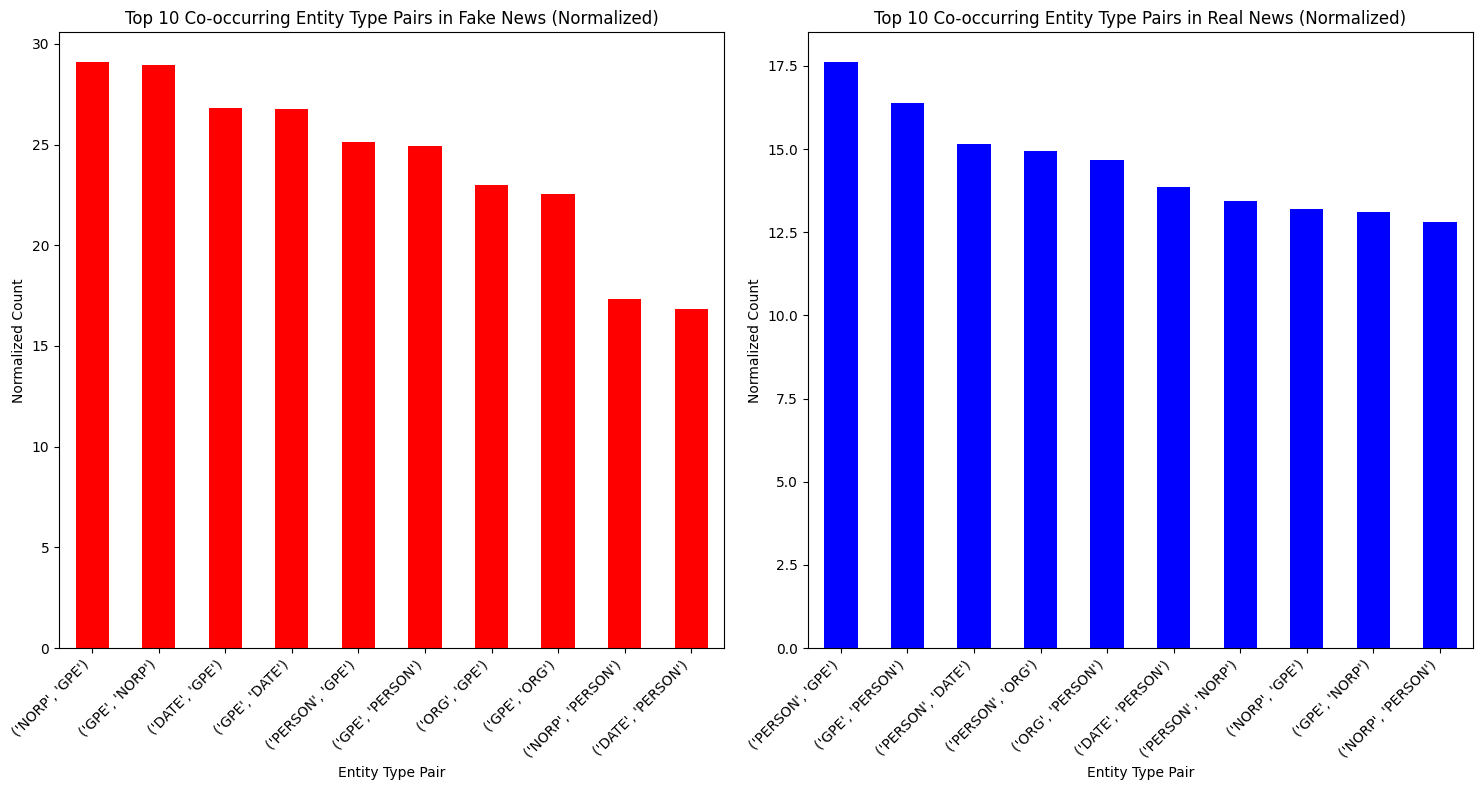

In [140]:
def get_entity_type_pairs(entities):
    return [pair for pair in combinations([ent[1] for ent in entities], 2) if pair[0] != pair[1]]

fake_entity_type_pairs = [pair for sublist in fake_news['entities'] for pair in get_entity_type_pairs(sublist)]
real_entity_type_pairs = [pair for sublist in real_news['entities'] for pair in get_entity_type_pairs(sublist)]

fake_pair_type_counts = Counter(fake_entity_type_pairs)
real_pair_type_counts = Counter(real_entity_type_pairs)

total_fake_articles = len(fake_news)
total_real_articles = len(real_news)

fake_pair_type_counts_normalized = {pair: count / total_fake_articles for pair, count in fake_pair_type_counts.items()}
real_pair_type_counts_normalized = {pair: count / total_real_articles for pair, count in real_pair_type_counts.items()}

fake_top_type_pairs_normalized = Counter(fake_pair_type_counts_normalized).most_common(10)
real_top_type_pairs_normalized = Counter(real_pair_type_counts_normalized).most_common(10)

fake_top_type_pairs_df = pd.DataFrame(fake_top_type_pairs_normalized, columns=['Entity Type Pair', 'Normalized Count'])
real_top_type_pairs_df = pd.DataFrame(real_top_type_pairs_normalized, columns=['Entity Type Pair', 'Normalized Count'])

fig, axes = plt.subplots(1, 2, figsize=(15, 8))

fake_top_type_pairs_df.plot(kind='bar', x='Entity Type Pair', y='Normalized Count', ax=axes[0], legend=False, color='red')
axes[0].set_title('Top 10 Co-occurring Entity Type Pairs in Fake News (Normalized)')
axes[0].set_ylabel('Normalized Count')
axes[0].set_xlabel('Entity Type Pair')
axes[0].set_xticklabels(fake_top_type_pairs_df['Entity Type Pair'], rotation=45, ha='right')

real_top_type_pairs_df.plot(kind='bar', x='Entity Type Pair', y='Normalized Count', ax=axes[1], legend=False, color='blue')
axes[1].set_title('Top 10 Co-occurring Entity Type Pairs in Real News (Normalized)')
axes[1].set_ylabel('Normalized Count')
axes[1].set_xlabel('Entity Type Pair')
axes[1].set_xticklabels(real_top_type_pairs_df['Entity Type Pair'], rotation=45, ha='right')

plt.tight_layout()
plt.show()

Looking at the plot above, we can see that the pair ('Person', 'Norp') occurs much more frequently in Real News, coherently with the observation above about single entity types frequency. This is even more insightful when we notice that it is the only pair that exhibits a substantial difference in frequency in the two scenarios, further strenghening out idea that it could be a very useful information to take into account. 

Let's now look at the number of people mentioned

Average number of persons mentioned in fake news: 4.790756170413457
Average number of persons mentioned in real news: 5.361924296102927

Summary statistics for number of persons in fake news:
count    6361.000000
mean        4.790756
std         4.975672
min         0.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        64.000000
Name: num_persons, dtype: float64

Summary statistics for number of persons in real news:
count    5363.000000
mean        5.361924
std         5.802714
min         0.000000
25%         2.000000
50%         4.000000
75%         7.000000
max       112.000000
Name: num_persons, dtype: float64


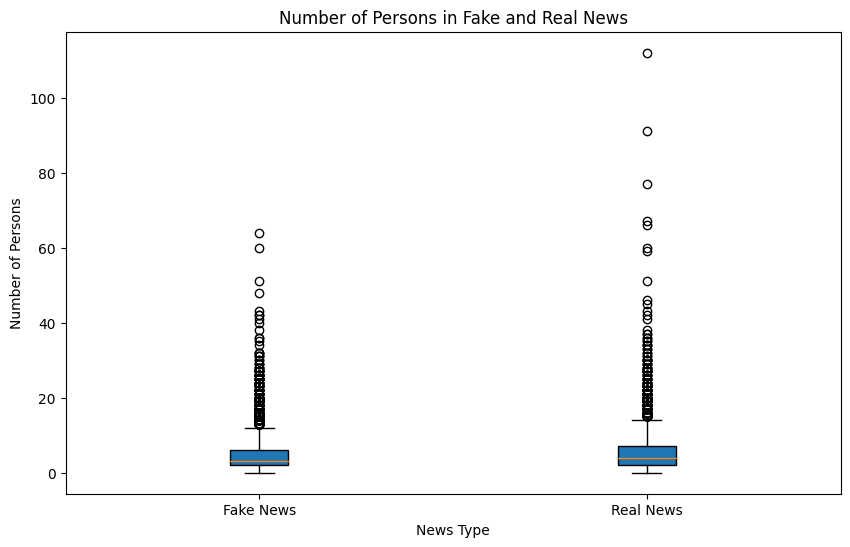

In [141]:
def count_persons(entities):
    return sum(1 for ent in entities if ent[1] == 'PERSON')

fake_news['num_persons'] = fake_news['entities'].apply(count_persons)
real_news['num_persons'] = real_news['entities'].apply(count_persons)

fake_avg_persons = fake_news['num_persons'].mean()
real_avg_persons = real_news['num_persons'].mean()

print(f"Average number of persons mentioned in fake news: {fake_avg_persons}")
print(f"Average number of persons mentioned in real news: {real_avg_persons}")

fake_summary_persons = fake_news['num_persons'].describe()
real_summary_persons = real_news['num_persons'].describe()

print("\nSummary statistics for number of persons in fake news:")
print(fake_summary_persons)
print("\nSummary statistics for number of persons in real news:")
print(real_summary_persons)

boxplot_data_persons = [fake_news['num_persons'], real_news['num_persons']]

plt.figure(figsize=(10, 6))
plt.boxplot(boxplot_data_persons, labels=['Fake News', 'Real News'], patch_artist=True)

plt.title('Number of Persons in Fake and Real News')
plt.ylabel('Number of Persons')
plt.xlabel('News Type')

plt.show()

In [142]:
def extract_entities_by_type(entities, entity_type):
    return [ent[0] for ent in entities if ent[1] == entity_type]


fake_persons = [person for entities in fake_news['entities'] for person in extract_entities_by_type(entities, 'PERSON')]
real_persons = [person for entities in real_news['entities'] for person in extract_entities_by_type(entities, 'PERSON')]

fake_organizations = [org for entities in fake_news['entities'] for org in extract_entities_by_type(entities, 'ORG')]
real_organizations = [org for entities in real_news['entities'] for org in extract_entities_by_type(entities, 'ORG')]


fake_person_counts = Counter(fake_persons).most_common(10)
real_person_counts = Counter(real_persons).most_common(10)

fake_org_counts = Counter(fake_organizations).most_common(10)
real_org_counts = Counter(real_organizations).most_common(10)

print("Top 10 persons in fake news:", fake_person_counts)
print("Top 10 persons in real news:", real_person_counts)

print("Top 10 organizations in fake news:", fake_org_counts)
print("Top 10 organizations in real news:", real_org_counts)

Top 10 persons in fake news: [('trumps', 2584), ('donald trump', 1989), ('clinton', 1534), ('hillary clinton', 651), ('donald trumps', 623), ('putin', 349), ('vladimir putin', 224), ('bush', 199), ('johnson', 181), ('eu', 177)]
Top 10 persons in real news: [('clinton', 1943), ('hillary clinton', 1426), ('donald trump', 1402), ('trumps', 384), ('bill clinton', 290), ('putin', 278), ('bush', 247), ('bernie', 243), ('donald trump s', 232), ('hillary', 215)]
Top 10 organizations in fake news: [('senate', 2309), ('congress', 1653), ('the white house', 1486), ('reuters', 1030), ('un', 953), ('white house', 944), ('fbi', 509), ('state', 419), ('the european union', 413), ('supreme court', 396)]
Top 10 organizations in real news: [('gop', 1271), ('fbi', 1076), ('the white house', 915), ('cnn', 857), ('congress', 721), ('senate', 688), ('fox news', 479), ('white house', 447), ('cia', 302), ('the republican party', 297)]


Let's now analyse the properties of the network on entities. The network is based on the co-occurece of entities: each entity is a node in the graph and the weight of each edge is the number of co-occurrences between two entities. Based on the graph, we can extract 'average centrality measures' of the entities mentioned in an article, to capture the difference in complexity and relationship structure in fake and real news.

In [143]:
import pandas as pd
import random
from collections import Counter
from itertools import combinations
import networkx as nx
import matplotlib.pyplot as plt


def get_entity_pairs(entities):
    return [pair for pair in combinations([ent[0] for ent in entities], 2) if pair[0] != pair[1]]

def add_edges_to_graph(G, pairs):
    for pair in pairs:
        if G.has_edge(pair[0], pair[1]):
            G[pair[0]][pair[1]]['weight'] += 1
        else:
            G.add_edge(pair[0], pair[1], weight=1)
    return G

def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    pagerank = nx.pagerank(G)
    clustering = nx.clustering(G)
    return degree_centrality, betweenness_centrality, closeness_centrality, pagerank, clustering

def compute_mean_centrality(entities, centrality_dict):
    centralities = [centrality_dict.get(ent[0], 0) for ent in entities]
    return sum(centralities) / len(centralities) if centralities else 0

all_entities = [ent[0] for sublist in data['entities'] for ent in sublist]
entity_counts = Counter(all_entities)

top_entities = [entity for entity, _ in entity_counts.most_common(500)]


data['filtered_entities'] = data['entities'].apply(lambda ents: [ent for ent in ents if ent[0] in top_entities])


data['entity_pairs'] = data['filtered_entities'].apply(get_entity_pairs)


all_pairs = [pair for sublist in data['entity_pairs'] for pair in sublist]


G = nx.Graph()
G = add_edges_to_graph(G, all_pairs)

print("Graph created with edges added")


print("Analyzing the network")


degree_centrality, betweenness_centrality, closeness_centrality, pagerank, clustering = compute_centrality_measures(G)

centrality_df = pd.DataFrame({
    'Entity': list(degree_centrality.keys()),
    'Degree Centrality': list(degree_centrality.values()),
    'Betweenness Centrality': list(betweenness_centrality.values()),
    'Closeness Centrality': list(closeness_centrality.values()),
    'PageRank': list(pagerank.values()),
    'Clustering Coefficient': list(clustering.values())
})

centrality_df = centrality_df.sort_values(by='Degree Centrality', ascending=False)

degree_centrality_dict = centrality_df.set_index('Entity')['Degree Centrality'].to_dict()
betweenness_centrality_dict = centrality_df.set_index('Entity')['Betweenness Centrality'].to_dict()
closeness_centrality_dict = centrality_df.set_index('Entity')['Closeness Centrality'].to_dict()
pagerank_dict = centrality_df.set_index('Entity')['PageRank'].to_dict()
clustering_dict = centrality_df.set_index('Entity')['Clustering Coefficient'].to_dict()

data['Mean Degree Centrality'] = data['filtered_entities'].apply(compute_mean_centrality, centrality_dict=degree_centrality_dict)
data['Mean Betweenness Centrality'] = data['filtered_entities'].apply(compute_mean_centrality, centrality_dict=betweenness_centrality_dict)
data['Mean Closeness Centrality'] = data['filtered_entities'].apply(compute_mean_centrality, centrality_dict=closeness_centrality_dict)
data['Mean PageRank'] = data['filtered_entities'].apply(compute_mean_centrality, centrality_dict=pagerank_dict)
data['Mean Clustering Coefficient'] = data['filtered_entities'].apply(compute_mean_centrality, centrality_dict=clustering_dict)

Graph created with edges added
Analyzing the network


<Figure size 1500x1000 with 0 Axes>

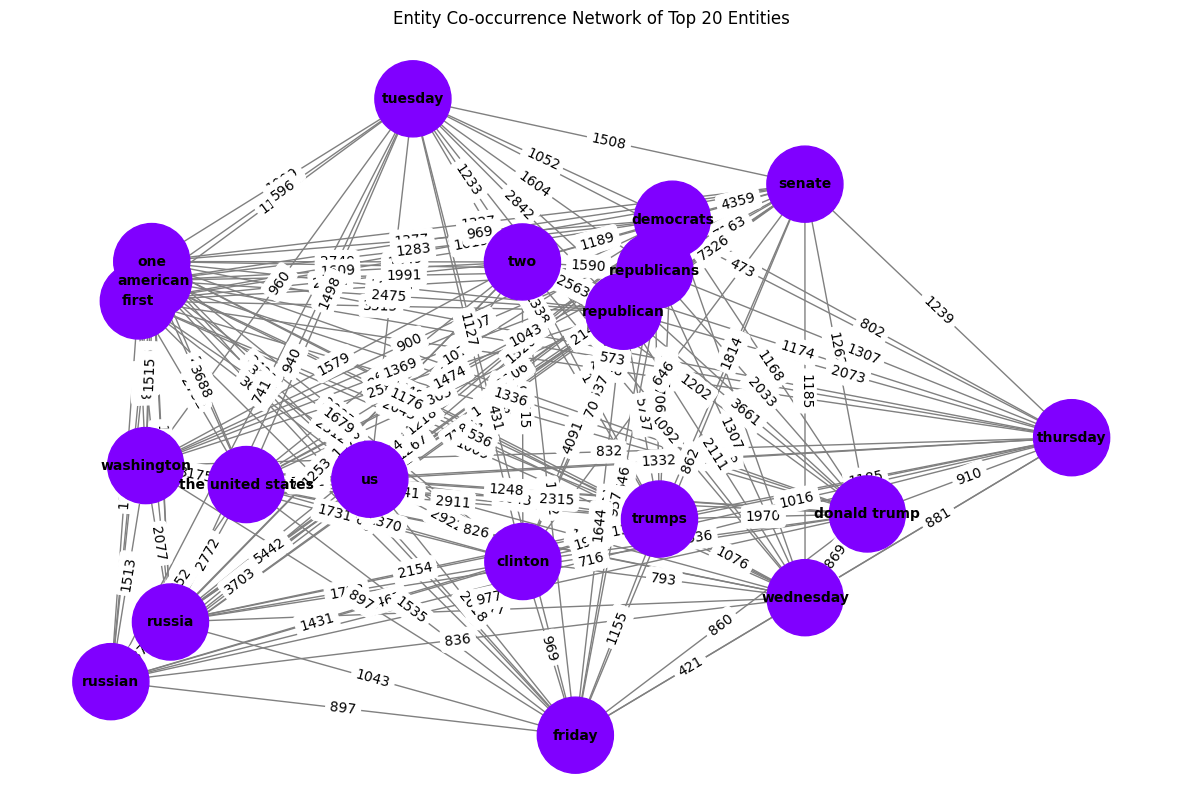

In [144]:
from networkx.algorithms import community

top_20_entities = [entity for entity, _ in entity_counts.most_common(20)]

# Create a subgraph with the top 20 entities
top_entity_subgraph = G.subgraph(top_20_entities)

# Perform community detection
communities = community.greedy_modularity_communities(top_entity_subgraph)

# Assign colors to nodes based on their community
community_map = {}
for i, com in enumerate(communities):
    for node in com:
        community_map[node] = i

# Drawing the simplified network graph
plt.figure(figsize=(15, 10))

# Using the spring layout with edge weights
pos = nx.spring_layout(top_entity_subgraph, k=0.2, weight='weight', iterations=100, scale=2)

# Creating a new figure and axes
fig, ax = plt.subplots(figsize=(15, 10))

# Drawing the graph
nx.draw(top_entity_subgraph, pos, ax=ax, with_labels=True, node_size=3000,
        node_color=[community_map[node] for node in top_entity_subgraph.nodes()],
        cmap=plt.cm.rainbow, font_size=10, font_color="black", edge_color="gray", linewidths=1, font_weight="bold")

# Adding edge labels (number of relations)
labels = nx.get_edge_attributes(top_entity_subgraph, 'weight')
nx.draw_networkx_edge_labels(top_entity_subgraph, pos, edge_labels=labels, ax=ax)

plt.title("Entity Co-occurrence Network of Top 20 Entities")
plt.show()

The graph shows the co-occurrence of the top 20 entities, the more they are related, the closer

# Feature Engineering

Let's start building basic features based on entities characteristics

Since we have seen that, despite the lower number of entities in Fake news, the majority of observations with 0 entities are truthful, it makes sense to create a dummy variable 'has_0_entities' which will provide even more insight about the number of entities. This will make the model able to capture this aspect of the data. 

In [145]:
data['num_entities'] = data['entities'].apply(len)
data['has_0_entities'] = data['num_entities'].apply(lambda x: 1 if x == 0 else 0)

Moreover, let's create features for the number of people and groups among the entities. 

In [146]:
def count_specific_entities(entities, entity_type):
    return sum(1 for ent in entities if ent[1] == entity_type)

data['num_people'] = data['entities'].apply(lambda x: count_specific_entities(x, 'PERSON'))
data['num_groups'] = data['entities'].apply(lambda x: count_specific_entities(x, 'GPE'))
data['num_data'] = data['entities'].apply(lambda x: count_specific_entities(x, 'data'))

As we've seen, fake news tend to have an higher proportion of entities POS which drive attention (subject, object, adjective). Let's create a feature for indicating the number of these instances, normalised by the number of entities in an article. 

In [147]:
data['norm_subj'] = data.apply(lambda row: row['num_subj'] / row['num_entities'] if row['num_entities'] > 0 else 0, axis=1)
data['norm_adj'] = data.apply(lambda row: row['num_adj'] / row['num_entities'] if row['num_entities'] > 0 else 0, axis=1)
data['norm_obj'] = data.apply(lambda row: row['num_obj'] / row['num_entities'] if row['num_entities'] > 0 else 0, axis=1)

Since Real news exhibit an higher frequency of the pair ('Person', 'Norp') with respect to Fake ones, let's introduce a dummy variable to account for the presence of this pair.

In [148]:
def has_person_gpe_pair(entities):
    pairs = combinations(entities, 2)
    for ent1, ent2 in pairs:
        if (ent1[1] == 'PERSON' and ent2[1] == 'GPE') or (ent1[1] == 'GPE' and ent2[1] == 'PERSON'):
            return 1
    return 0

# Apply the function to create the dummy variable
data['has_pair_PERS_GPE'] = data['entities'].apply(has_person_gpe_pair)

As we've seen, Real news tend to mention more unique entity types while Fake ones tend to focus on fewer ones to capture attention. Let's create a feature to capture this difference

In [149]:
data['unique_entity_types_count'] = data['entities'].apply(count_unique_entity_types)

In [150]:
data

,Unified_Verdict,Text,entities,entity_verb_ratio,sentiment,entities_relations_pos,relations,num_subj,num_adj,num_obj,...,num_entities,has_0_entities,num_people,num_groups,num_data,norm_subj,norm_adj,norm_obj,has_pair_PERS_GPE,unique_entity_types_count
16870,1.0,iranian commander issued stark warning to iraq...,"[(iranian, NORP), (iraqi, NORP), (kirkuksulaim...",0.866197,-0.9954,"([(iranian, NORP), (iraqi, NORP), (kirkuksulai...","[(of, prep, couple, TIME), (hours, pobj, of, T...",11,44,36,...,123,0,10,43,0,0.089431,0.357724,0.292683,1,8
1912,-1.0,trump just got ripped apart after demanding cl...,"[(demanding clinton, PERSON), (tweetsdonald tr...",0.571429,-0.9784,"([(demanding clinton, PERSON), (tweetsdonald t...",[],10,4,6,...,48,0,23,2,0,0.208333,0.083333,0.125000,1,7
13421,1.0,eu agrees registration rules for drones downlo...,"[(europe, LOC), (europe, LOC), (european union...",0.457627,0.9153,"([(europe, LOC), (europe, LOC), (european unio...",[],2,5,8,...,27,0,2,0,0,0.074074,0.185185,0.296296,0,7
10771,1.0,facebook twitter support apple on encryption d...,[(fbisan francisco reuters facebook inc fbo an...,0.407407,0.9892,([(fbisan francisco reuters facebook inc fbo a...,[],1,2,7,...,22,0,4,3,0,0.045455,0.090909,0.318182,1,7
10972,1.0,civil rights activist deray mckesson running f...,"[(mckesson, PERSON), (baltimore mckesson, ORG)...",0.673913,-0.9886,"([(mckesson, PERSON), (baltimore mckesson, ORG...",[],5,6,13,...,31,0,6,4,0,0.161290,0.193548,0.419355,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13517,1.0,frances macron to give saudi arabia extremist ...,"[(saudi arabia, GPE), (reuters, ORG), (french,...",0.589286,0.6485,"([(saudi arabia, GPE), (reuters, ORG), (french...",[],5,9,14,...,33,0,3,13,0,0.151515,0.272727,0.424242,1,5
13823,1.0,factbox proposals of main parties in honduras ...,"[(hondurans, NORP), (sunday, DATE), (second, O...",0.303797,-0.5854,"([(hondurans, NORP), (sunday, DATE), (second, ...","[(of, prep, university, ORG), (york, pobj, of,...",0,6,15,...,24,0,2,1,0,0.000000,0.250000,0.625000,1,7
13696,-1.0,not kidding hillarys state department blocked ...,"[(muslim, NORP), (florida, GPE), (hillary, PER...",0.584416,0.6374,"([(muslim, NORP), (florida, GPE), (hillary, PE...",[],8,8,14,...,45,0,10,12,0,0.177778,0.177778,0.311111,1,8
17238,-1.0,breaking obamas doj to fast track million to t...,"[(charleston, GPE), (about million, CARDINAL),...",0.923077,-0.8271,"([(charleston, GPE), (about million, CARDINAL)...",[],2,1,6,...,12,0,1,5,0,0.166667,0.083333,0.500000,1,4


# Models

Before training our model, we may want to convert the 'Text' column in a type of input suitable for a Machine Learning Algorithm. In order to do this, we could use an embedder called 'Sentence-BERT (SBERT)'. This method will turn the text into a vectorized representation. 

In [151]:
'''
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

data['sentence_embeddings'] = data['Text'].apply(lambda x: model.encode(x))
'''

"\nfrom sentence_transformers import SentenceTransformer\n\nmodel = SentenceTransformer('paraphrase-MiniLM-L6-v2')\n\ndata['sentence_embeddings'] = data['Text'].apply(lambda x: model.encode(x))\n"

Since we mainly want to capture the explanatory power of the features we created, we won't use the embedding of the text. We'll only include numerical features. 

In [152]:
data = data.select_dtypes(include=[np.number])
data1 = data.copy()

In [153]:
data1

,Unified_Verdict,entity_verb_ratio,sentiment,num_subj,num_adj,num_obj,text_length,Mean Degree Centrality,Mean Betweenness Centrality,Mean Closeness Centrality,...,num_entities,has_0_entities,num_people,num_groups,num_data,norm_subj,norm_adj,norm_obj,has_pair_PERS_GPE,unique_entity_types_count
16870,1.0,0.866197,-0.9954,11,44,36,1147,0.751804,0.000880,0.825980,...,123,0,10,43,0,0.089431,0.357724,0.292683,1,8
1912,-1.0,0.571429,-0.9784,10,4,6,605,0.920002,0.001370,0.932741,...,48,0,23,2,0,0.208333,0.083333,0.125000,1,7
13421,1.0,0.457627,0.9153,2,5,8,481,0.821443,0.001086,0.863338,...,27,0,2,0,0,0.074074,0.185185,0.296296,0,7
10771,1.0,0.407407,0.9892,1,2,7,432,0.876420,0.001257,0.903097,...,22,0,4,3,0,0.045455,0.090909,0.318182,1,7
10972,1.0,0.673913,-0.9886,5,6,13,404,0.905589,0.001438,0.926060,...,31,0,6,4,0,0.161290,0.193548,0.419355,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13517,1.0,0.589286,0.6485,5,9,14,350,0.834053,0.001045,0.866952,...,33,0,3,13,0,0.151515,0.272727,0.424242,1,5
13823,1.0,0.303797,-0.5854,0,6,15,536,0.858332,0.001282,0.896225,...,24,0,2,1,0,0.000000,0.250000,0.625000,1,7
13696,-1.0,0.584416,0.6374,8,8,14,535,0.909648,0.001300,0.922487,...,45,0,10,12,0,0.177778,0.177778,0.311111,1,8
17238,-1.0,0.923077,-0.8271,2,1,6,147,0.798168,0.000939,0.846176,...,12,0,1,5,0,0.166667,0.083333,0.500000,1,4


In [154]:
feature_columns = ['text_length',
    'entity_verb_ratio', 'sentiment',
    'num_subj', 'num_adj', 'num_obj', 'num_entities', 'has_0_entities', 
    'num_people', 'num_groups', 'num_data', 'norm_subj', 'norm_adj', 
    'norm_obj', 'has_pair_PERS_GPE', 'unique_entity_types_count', 'Mean Degree Centrality',
    'Mean Betweenness Centrality',	'Mean Closeness Centrality',	'Mean PageRank',	'Mean Clustering Coefficient'
]


X = data1.drop(columns=['Unified_Verdict'])
y = data1['Unified_Verdict']

In [155]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, classification_report
from sklearn.model_selection import GridSearchCV

# Pipeline and Model evaluation Function

In [156]:
def evaluate_model(pipeline, X_train, X_test, y_train, y_test, exclude_column=None):
    
    if exclude_column:
        X_train = X_train.drop(columns=[exclude_column])
        X_test = X_test.drop(columns=[exclude_column])
    
    original_columns = list(X_train.columns)
    
    if 'sentence_embeddings' in X_train.columns and exclude_column != 'sentence_embeddings':
        X_train_embeddings = np.vstack(X_train['sentence_embeddings'])
        X_test_embeddings = np.vstack(X_test['sentence_embeddings'])
        
        X_train = X_train.drop(columns=['sentence_embeddings'])
        X_test = X_test.drop(columns=['sentence_embeddings'])

        original_columns = list(X_train.columns) + [f'embedding_{i}' for i in range(X_train_embeddings.shape[1])]

        X_train = np.hstack((X_train.values, X_train_embeddings))
        X_test = np.hstack((X_test.values, X_test_embeddings))

    cv_predictions = cross_val_predict(pipeline, X_train, y_train, cv=5)

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)
    y_proba = pipeline.predict_proba(X_test)[:, 1]
  
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)
    print("Precision:", precision)
     
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "recall": recall,
        "precision": precision,
        "roc_auc": roc_auc
    }, original_columns


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [157]:
def plot_feature_importances(pipeline, original_columns):
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        classifier = pipeline.named_steps['classifier']
        feature_importances = classifier.feature_importances_
     
        feature_importance_dict = dict(zip(original_columns, feature_importances))

        embedding_features = [col for col in original_columns if col.startswith('embedding_')]
        if embedding_features:
            embedding_importance_sum = sum(feature_importance_dict.pop(col) for col in embedding_features)

        if len(feature_importance_dict) != len(original_columns) - len(embedding_features) + (1 if embedding_features else 0):
            raise ValueError("Mismatch between feature importances and original columns length")

        sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

        sorted_columns, sorted_importances = zip(*sorted_features)
        

        plt.figure(figsize=(12, 8))
        plt.barh(sorted_columns, sorted_importances, color='skyblue')
        plt.xlabel('Feature Importance')
        plt.ylabel('Feature')
        plt.title('Feature Importances in Classifier')
        plt.show()
    else:
        raise AttributeError("Classifier does not have 'feature_importances_' attribute")


In [173]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_importances2(pipeline, original_columns, top_n=5):
    if hasattr(pipeline.named_steps['classifier'], 'feature_importances_'):
        classifier = pipeline.named_steps['classifier']
        feature_importances = classifier.feature_importances_
        
        feature_importance_dict = dict(zip(original_columns, feature_importances))

        # Handle embedding features separately if they exist
        embedding_features = [col for col in original_columns if col.startswith('embedding_')]
        if embedding_features:
            embedding_importance_sum = sum(feature_importance_dict.pop(col) for col in embedding_features)
            feature_importance_dict['embedding_sum'] = embedding_importance_sum

        # Ensure the lengths match after accounting for embedding features
        if len(feature_importance_dict) != len(original_columns) - len(embedding_features) + (1 if embedding_features else 0):
            raise ValueError("Mismatch between feature importances and original columns length")

        # Sort features by importance and select top N
        sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)[:top_n]

        sorted_columns, sorted_importances = zip(*sorted_features)
        
        # Plotting
        plt.figure(figsize=(12, 8))
        colors = sns.color_palette("husl", len(sorted_importances))  # Use Husl color palette for a colorful plot
        plt.barh(sorted_columns, sorted_importances, color=colors)
        plt.xlabel('Feature Importance', fontsize=14)
        plt.ylabel('Feature', fontsize=14)
        plt.title(f'Top {top_n} Feature Importances in Classifier', fontsize=16)
        plt.gca().invert_yaxis()  # Invert y-axis to have the highest importance on top

        # Adding values to bars
        for index, value in enumerate(sorted_importances):
            plt.text(value, index, f'{value:.4f}', va='center', ha='right', color='black', fontsize=12)

        plt.show()
    else:
        raise AttributeError("Classifier does not have 'feature_importances_' attribute")


# Random Forest

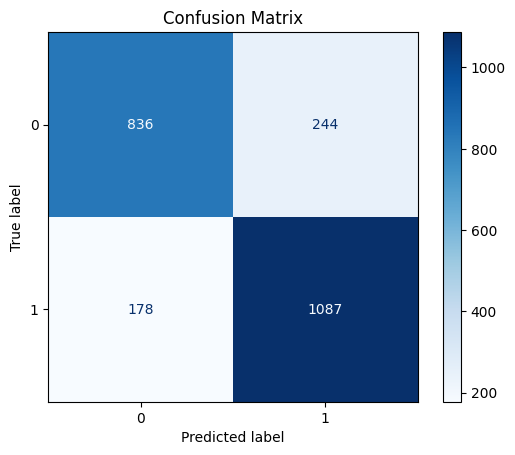

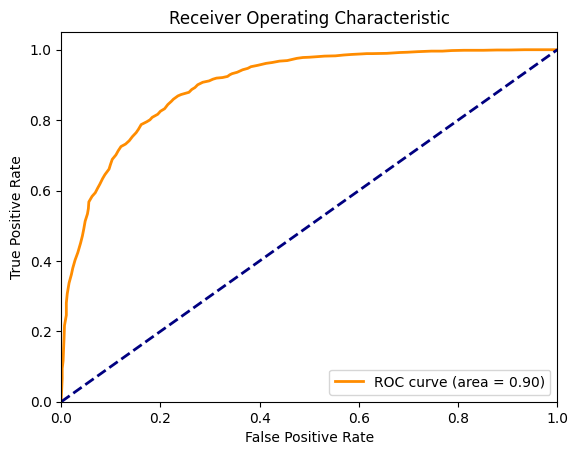

Accuracy: 0.8200426439232409
F1 Score: 0.837442218798151
Recall: 0.8592885375494071
Precision: 0.816679188580015


In [158]:
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

results_rf, original_columns_rf = evaluate_model(pipeline_rf, X_train, X_test, y_train, y_test)

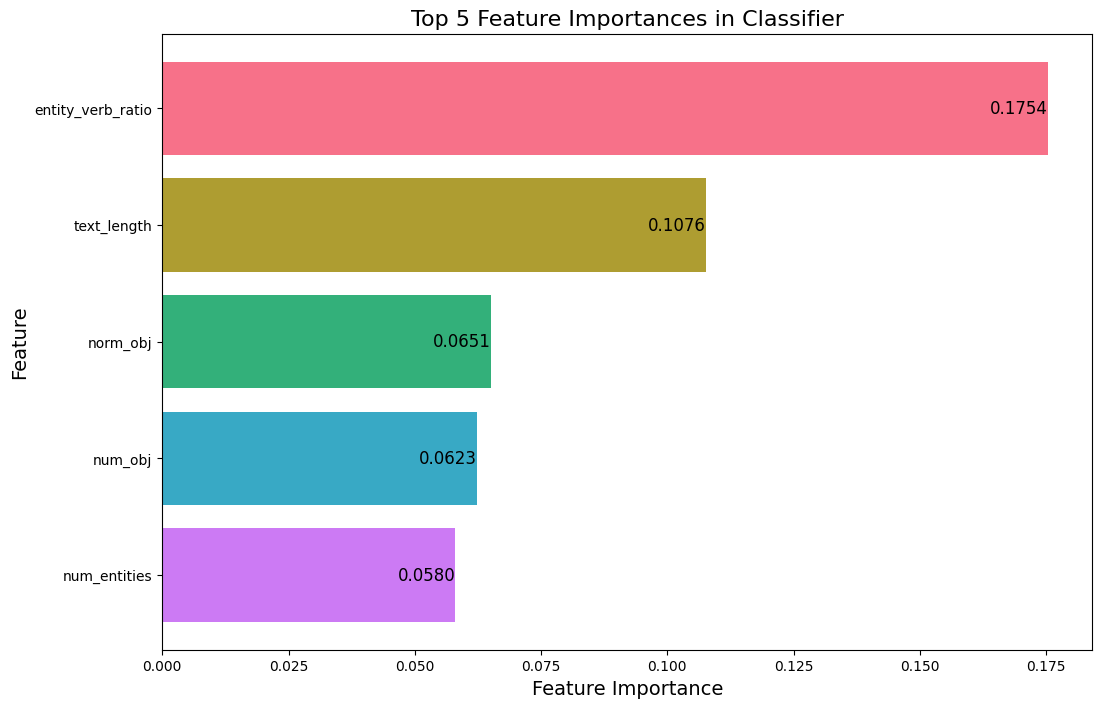

In [174]:
plot_feature_importances2(pipeline_rf, original_columns_rf)

# SVM classifier

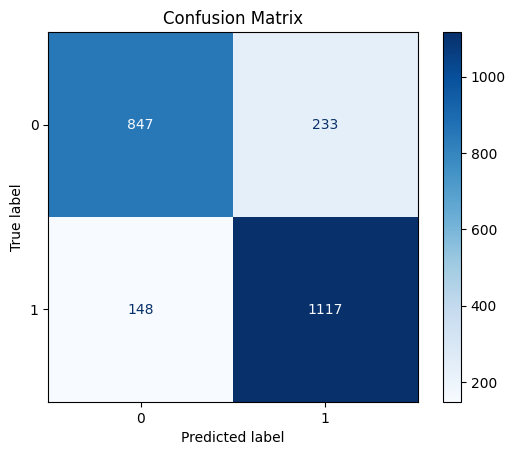

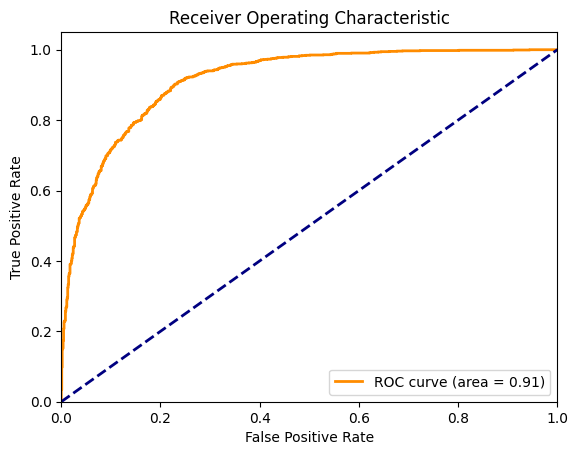

Accuracy: 0.8375266524520256
F1 Score: 0.8543021032504781
Recall: 0.88300395256917
Precision: 0.8274074074074074


In [160]:
from sklearn.svm import SVC

pipeline_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(probability=True, random_state=42))
])

results_svm, original_columns_svm = evaluate_model(pipeline_svm, X_train, X_test, y_train, y_test)

# XGBoost Classifier

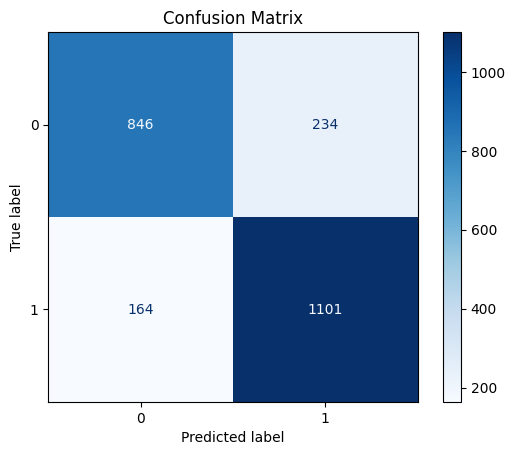

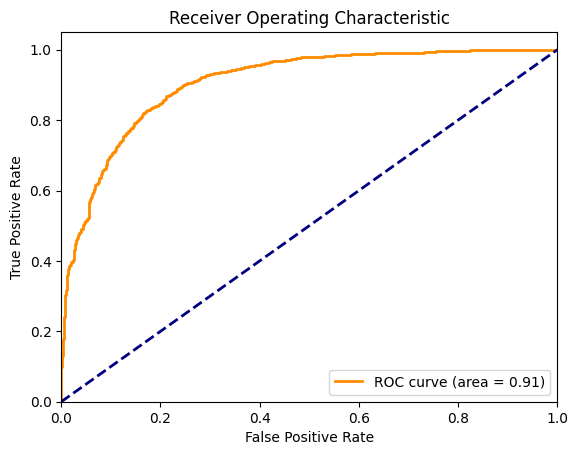

Accuracy: 0.8302771855010661
F1 Score: 0.8469230769230768
Recall: 0.8703557312252964
Precision: 0.8247191011235955


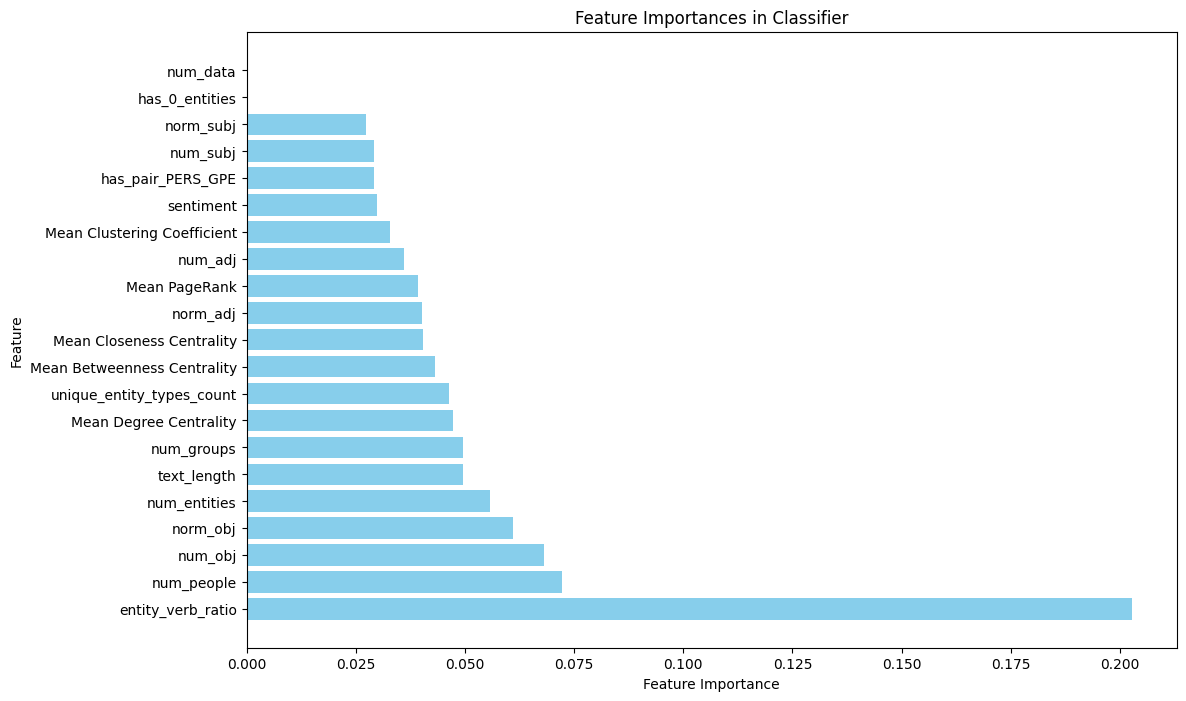

In [161]:
from xgboost import XGBClassifier

y_train_xgb = np.where(y_train == -1, 0, y_train)
y_test_xgb = np.where(y_test == -1, 0, y_test)

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

results_xgb, original_columns_xgb = evaluate_model(pipeline_xgb, X_train, X_test, y_train_xgb, y_test_xgb)
plot_feature_importances(pipeline_xgb, original_columns_xgb)

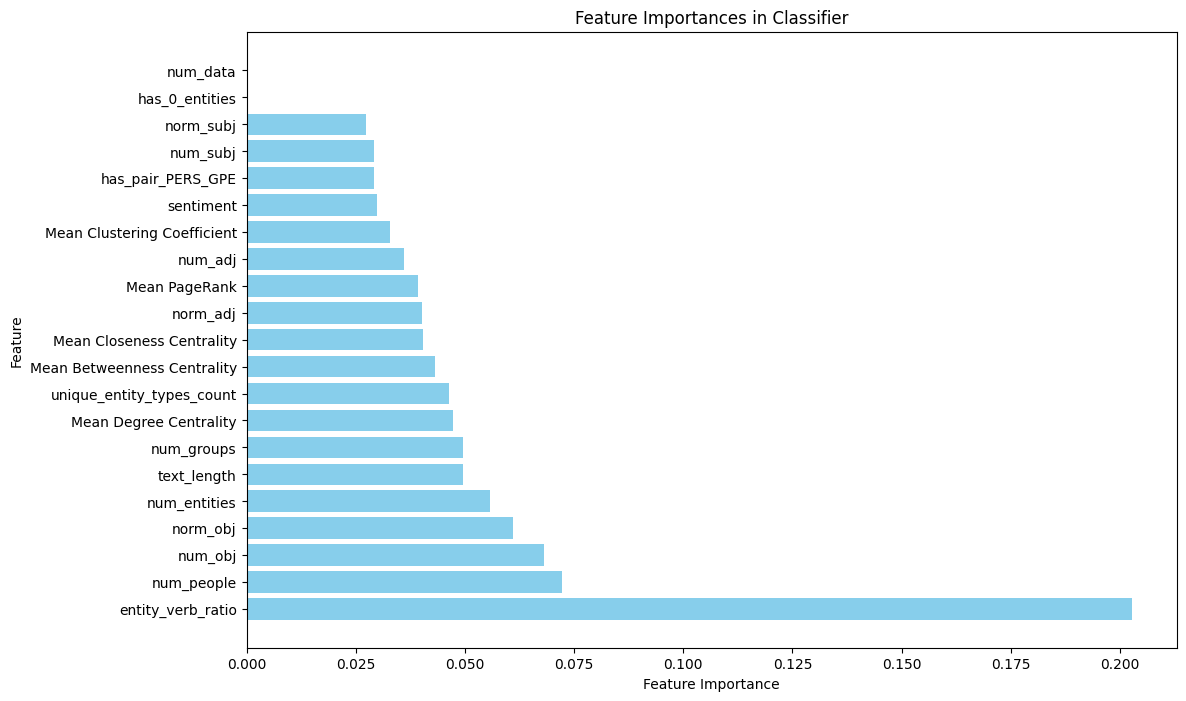

In [162]:
plot_feature_importances(pipeline_xgb, original_columns_xgb)

# AdaBoost

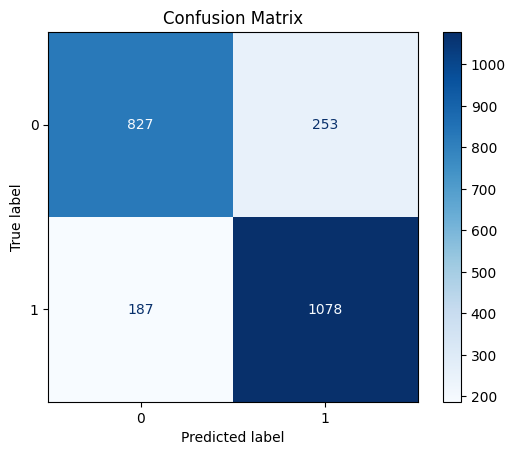

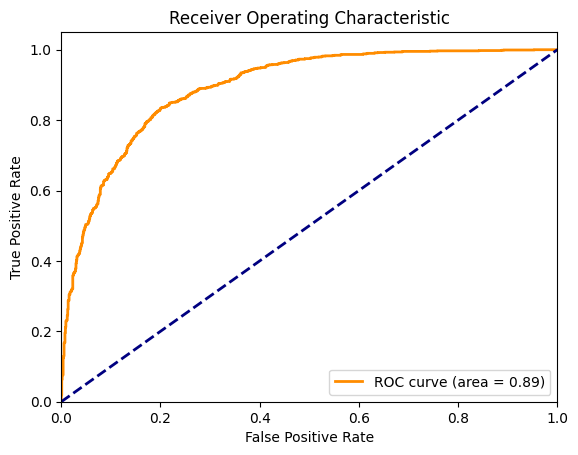

Accuracy: 0.8123667377398721
F1 Score: 0.8305084745762712
Recall: 0.8521739130434782
Precision: 0.8099173553719008


In [163]:
from sklearn.ensemble import AdaBoostClassifier

pipeline_ada = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', AdaBoostClassifier(n_estimators=100, random_state=42))
])

results_ada, original_columns_ada = evaluate_model(pipeline_ada, X_train, X_test, y_train, y_test)

In this particular problem, we aim to strike a balance between accuracy and recall. Wrongfully flagging a real news as fake could be leading to censorship, while not detecting a fake news could result in a dangerous spread of misleading information. That is why I decided to mainly consider F1-score metric and ROC in order to assess the best model. 

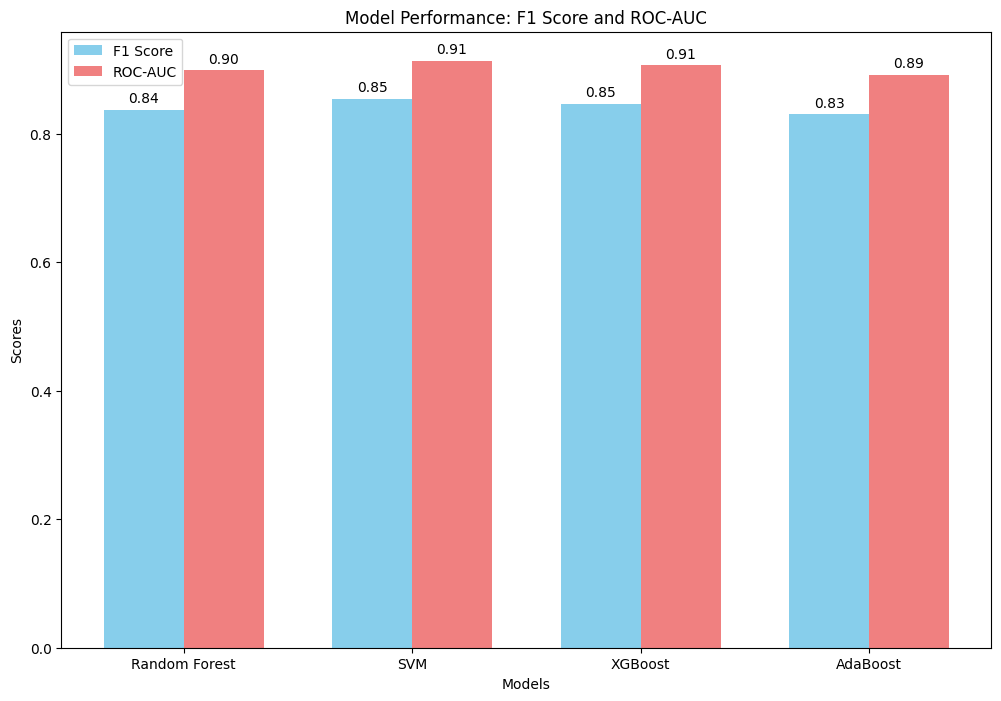

In [164]:
models = ['Random Forest', 'SVM', 'XGBoost', 'AdaBoost']
f1_scores = [results_rf['f1_score'], results_svm['f1_score'], results_xgb['f1_score'], results_ada['f1_score']]
roc_aucs = [results_rf['roc_auc'], results_svm['roc_auc'], results_xgb['roc_auc'], results_ada['roc_auc']]

bar_width = 0.35
index = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(index, f1_scores, bar_width, label='F1 Score', color='skyblue')
bars2 = ax.bar(index + bar_width, roc_aucs, bar_width, label='ROC-AUC', color='lightcoral')

ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Model Performance: F1 Score and ROC-AUC')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(models)
ax.legend()

def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

plt.show()

As we can clearly see from the plot, SVM and XGBoost turned out to be the best models from both a F1 and a ROC perspective